# LGM Internship - Lets Grow More
#### Author: Harshit Singh
## BEGINNER LEVEL TASK
#### Task3 - VIP Data Science Task
### Music Recommendation

Music recommender system can suggest songs to users based on their listening pattern.

In [170]:
#importing libraries
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
import gc
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import missingno as msno
from sklearn.model_selection import cross_val_score,GridSearchCV,train_test_split
from sklearn.tree import DecisionTreeClassifier,ExtraTreeClassifier
from sklearn.metrics import roc_curve,roc_auc_score,classification_report,mean_squared_error,accuracy_score
from sklearn.ensemble import GradientBoostingClassifier,RandomForestClassifier,BaggingClassifier,VotingClassifier,AdaBoostClassifier
import lightgbm as lgb
import datetime
import math

In [171]:
import lightgbm as lgb
from sklearn.metrics import precision_recall_curve,roc_auc_score,classification_report,roc_curve
from tqdm import tqdm

In [172]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [237]:
train = reduce_mem_usage(pd.read_csv('/content/sample_data/train.csv'))
test = reduce_mem_usage(pd.read_csv('/content/sample_data/test.csv'))
sei = pd.read_csv('/content/sample_data/song_extra_info.csv')
members = pd.read_csv('/content/sample_data/members.csv',parse_dates=['registration_init_time','expiration_date'])
songs = pd.read_csv('/content/sample_data/songs.csv')

Memory usage of dataframe is 143.44 MB
Memory usage after optimization is: 45.37 MB
Decreased by 68.4%
Memory usage of dataframe is 117.04 MB
Memory usage after optimization is: 44.23 MB
Decreased by 62.2%


In [174]:
train.head()

,msno,song_id,source_system_tab,source_screen_name,source_type,target
0,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,BBzumQNXUHKdEBOB7mAJuzok+IJA1c2Ryg/yzTF6tik=,explore,Explore,online-playlist,1.0
1,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,bhp/MpSNoqoxOIB+/l8WPqu6jldth4DIpCm3ayXnJqM=,my library,Local playlist more,local-playlist,1.0
2,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,JNWfrrC7zNN7BdMpsISKa4Mw+xVJYNnxXh3/Epw7QgY=,my library,Local playlist more,local-playlist,1.0
3,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,2A87tzfnJTSWqD7gIZHisolhe4DMdzkbd6LzO1KHjNs=,my library,Local playlist more,local-playlist,1.0
4,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,3qm6XTZ6MOCU11x8FIVbAGH5l5uMkT3/ZalWG1oo2Gc=,explore,Explore,online-playlist,1.0


In [175]:
test.head()

,id,msno,song_id,source_system_tab,source_screen_name,source_type
0,0,V8ruy7SGk7tDm3zA51DPpn6qutt+vmKMBKa21dp54uM=,WmHKgKMlp1lQMecNdNvDMkvIycZYHnFwDT72I5sIssc=,my library,Local playlist more,local-library
1,1,V8ruy7SGk7tDm3zA51DPpn6qutt+vmKMBKa21dp54uM=,y/rsZ9DC7FwK5F2PK2D5mj+aOBUJAjuu3dZ14NgE0vM=,my library,Local playlist more,local-library
2,2,/uQAlrAkaczV+nWCd2sPF2ekvXPRipV7q0l+gbLuxjw=,8eZLFOdGVdXBSqoAv5nsLigeH2BvKXzTQYtUM53I0k4=,discover,NaN,song-based-playlist
3,3,1a6oo/iXKatxQx4eS9zTVD+KlSVaAFbTIqVvwLC1Y0k=,ztCf8thYsS4YN3GcIL/bvoxLm/T5mYBVKOO4C9NiVfQ=,radio,Radio,radio
4,4,1a6oo/iXKatxQx4eS9zTVD+KlSVaAFbTIqVvwLC1Y0k=,MKVMpslKcQhMaFEgcEQhEfi5+RZhMYlU3eRDpySrH8Y=,radio,Radio,radio


In [176]:
members.head()

,msno,city,bd,gender,registered_via,registration_init_time,expiration_date
0,XQxgAYj3klVKjR3oxPPXYYFp4soD4TuBghkhMTD4oTw=,1,0,NaN,7,2011-08-20,2017-09-20
1,UizsfmJb9mV54qE9hCYyU07Va97c0lCRLEQX3ae+ztM=,1,0,NaN,7,2015-06-28,2017-06-22
2,D8nEhsIOBSoE6VthTaqDX8U6lqjJ7dLdr72mOyLya2A=,1,0,NaN,4,2016-04-11,2017-07-12
3,mCuD+tZ1hERA/o5GPqk38e041J8ZsBaLcu7nGoIIvhI=,1,0,NaN,9,2015-09-06,2015-09-07
4,q4HRBfVSssAFS9iRfxWrohxuk9kCYMKjHOEagUMV6rQ=,1,0,NaN,4,2017-01-26,2017-06-13


In [177]:
songs.head()

,song_id,song_length,genre_ids,artist_name,composer,lyricist,language
0,CXoTN1eb7AI+DntdU1vbcwGRV4SCIDxZu+YD8JP8r4E=,247640,465,張信哲 (Jeff Chang),董貞,何啟弘,3.0
1,o0kFgae9QtnYgRkVPqLJwa05zIhRlUjfF7O1tDw0ZDU=,197328,444,BLACKPINK,TEDDY| FUTURE BOUNCE| Bekuh BOOM,TEDDY,31.0
2,DwVvVurfpuz+XPuFvucclVQEyPqcpUkHR0ne1RQzPs0=,231781,465,SUPER JUNIOR,NaN,NaN,31.0
3,dKMBWoZyScdxSkihKG+Vf47nc18N9q4m58+b4e7dSSE=,273554,465,S.H.E,湯小康,徐世珍,3.0
4,W3bqWd3T+VeHFzHAUfARgW9AvVRaF4N5Yzm4Mr6Eo/o=,140329,726,貴族精選,Traditional,Traditional,52.0


In [178]:
members.shape
train.info()
print("\n")
songs.info()
print("\n")
members.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2377804 entries, 0 to 2377803
Data columns (total 6 columns):
 #   Column              Dtype   
---  ------              -----   
 0   msno                category
 1   song_id             category
 2   source_system_tab   category
 3   source_screen_name  category
 4   source_type         category
 5   target              float16 
dtypes: category(5), float16(1)
memory usage: 32.2 MB


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2296320 entries, 0 to 2296319
Data columns (total 7 columns):
 #   Column       Dtype  
---  ------       -----  
 0   song_id      object 
 1   song_length  int64  
 2   genre_ids    object 
 3   artist_name  object 
 4   composer     object 
 5   lyricist     object 
 6   language     float64
dtypes: float64(1), int64(1), object(5)
memory usage: 122.6+ MB


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34403 entries, 0 to 34402
Data columns (total 7 columns):
 #   Column                  Non-Null Co

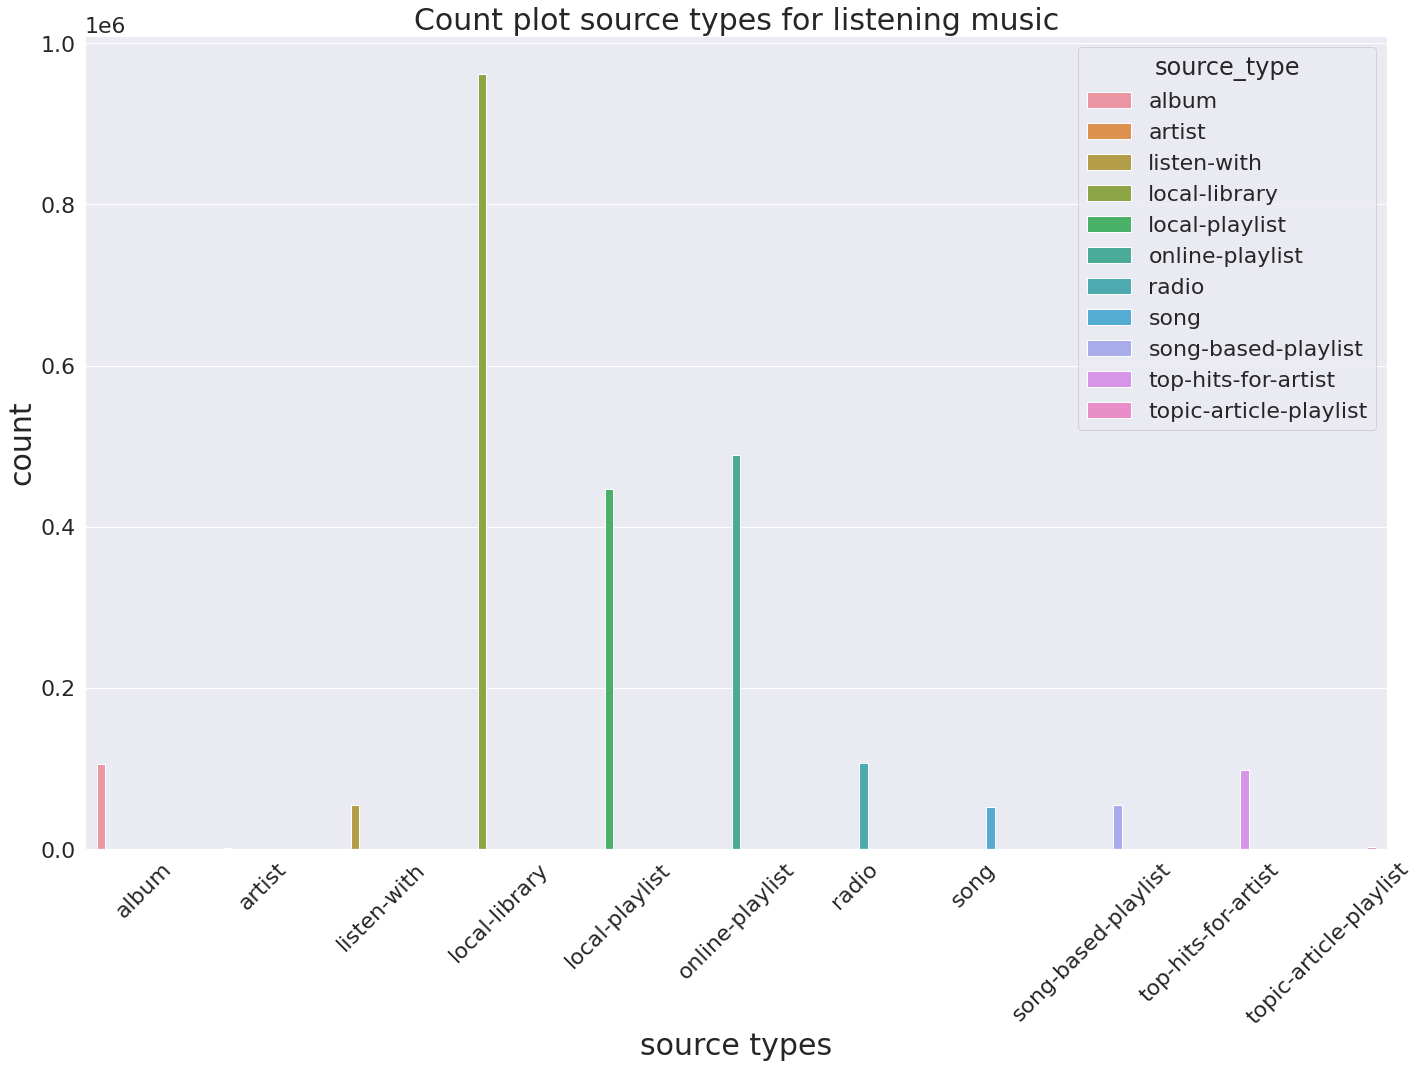

In [179]:
plt.figure(figsize=(20,15))
sns.set(font_scale=2)
sns.countplot(x='source_type',hue='source_type',data=train)
sns.set(style="darkgrid")
plt.xlabel('source types',fontsize=30)
plt.ylabel('count',fontsize=30)
plt.xticks(rotation='45')
plt.title('Count plot source types for listening music',fontsize=30)
plt.tight_layout()

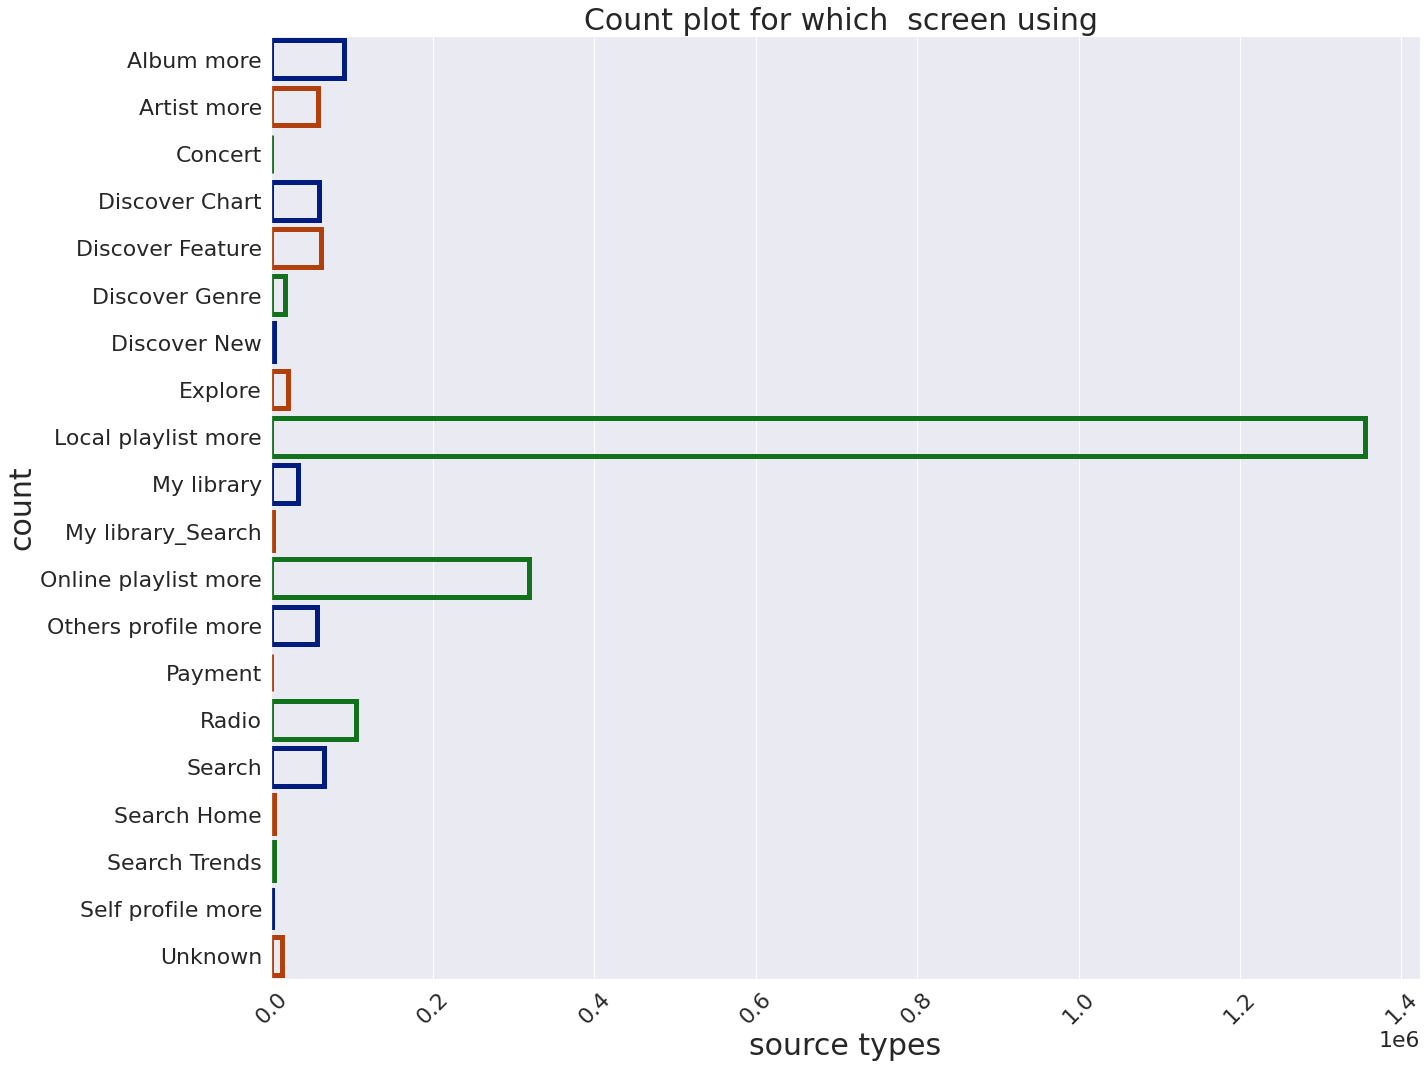

In [180]:
plt.figure(figsize=(20,15))
sns.set(font_scale=2)
sns.countplot(y='source_screen_name',data=train,facecolor=(0,0,0,0),linewidth=5,edgecolor=sns.color_palette('dark',3))
sns.set(style="darkgrid")
plt.xlabel('source types',fontsize=30)
plt.ylabel('count',fontsize=30)
plt.xticks(rotation='45')
plt.title('Count plot for which  screen using ',fontsize=30)
plt.tight_layout()

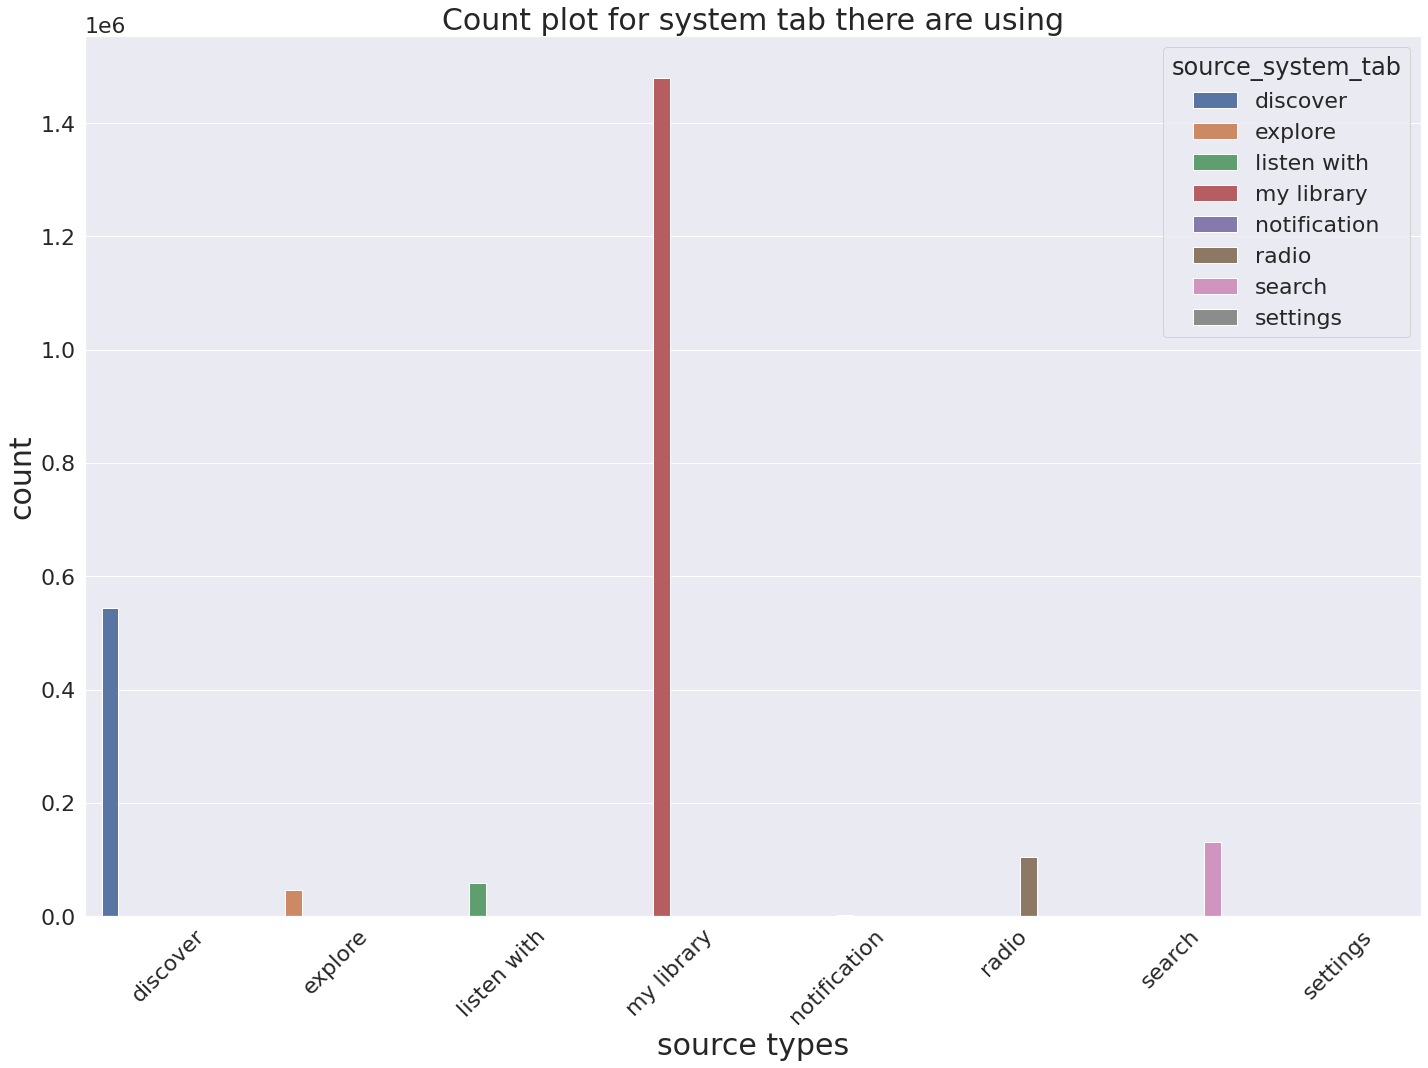

In [181]:
plt.figure(figsize=(20,15))
sns.set(font_scale=2)
sns.countplot(x='source_system_tab',hue='source_system_tab',data=train)
sns.set(style="darkgrid")
plt.xlabel('source types',fontsize=30)
plt.ylabel('count',fontsize=30)
plt.xticks(rotation='45')
plt.title('Count plot for system tab there are using',fontsize=30)
plt.tight_layout()

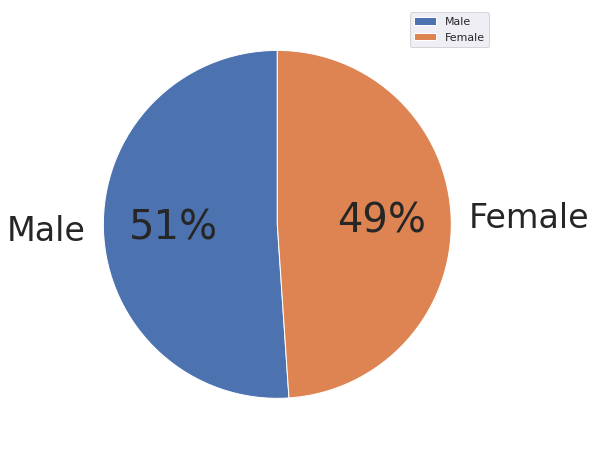

In [182]:
import matplotlib as mpl

mpl.rcParams['font.size'] = 40.0
labels = ['Male','Female']
plt.figure(figsize = (8, 8))
sizes = pd.value_counts(members.gender)
patches, texts, autotexts = plt.pie(sizes, 
                                    labels=labels, autopct='%.0f%%',
                                    shadow=False, radius=1,startangle=90)
for t in texts:
    t.set_size('smaller')
plt.legend()
plt.show()

my library      1480255
discover         544480
search           131386
radio            105335
listen with       59258
explore           46449
notification       1415
settings            955
Name: source_system_tab, dtype: int64


<Figure size 1440x1440 with 0 Axes>

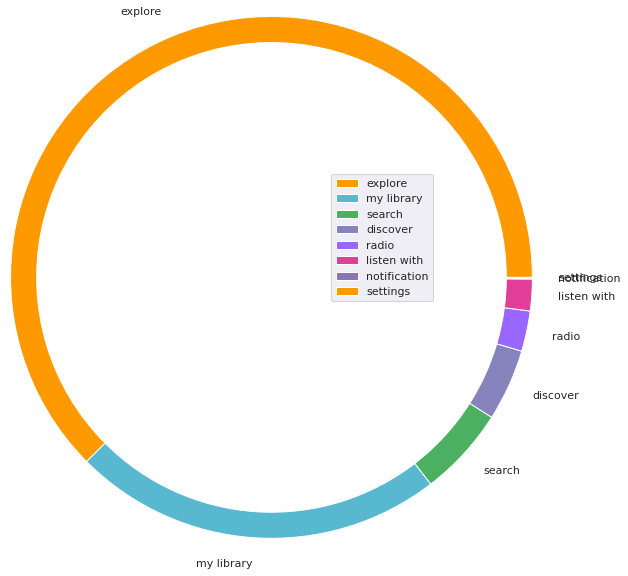

In [183]:
import matplotlib.pyplot as plt
mpl.rcParams['font.size'] = 40.0
plt.figure(figsize = (20, 20)) 
# Make data: I have 3 groups and 7 subgroups
group_names=['explore','my library','search','discover','radio','listen with','notification','settings']
group_size=pd.value_counts(train.source_system_tab)
print(group_size)
subgroup_names=['Male','Female']
subgroup_size=pd.value_counts(members.gender)
 
# Create colors
a, b, c,d,e,f,g,h=[plt.cm.autumn, plt.cm.GnBu, plt.cm.YlGn,plt.cm.Purples,plt.cm.cool,plt.cm.RdPu,plt.cm.BuPu,plt.cm.bone]
 
# First Ring (outside)
fig, ax = plt.subplots()
ax.axis('equal')
mypie, texts= ax.pie(group_size, radius=3.0,labels=group_names, colors=[a(0.6), b(0.6), c(0.6),d(0.6), e(0.6), f(0.6),g(0.6)])
plt.setp( mypie, width=0.3, edgecolor='white')
 
# Second Ring (Inside)
#mypie2, texts1 = ax.pie(subgroup_size, radius=3.0-0.3, labels=subgroup_names, labeldistance=0.7, colors=[h(0.5), b(0.4)])
#plt.setp( mypie2, width=0.3, edgecolor='white')
#plt.margins(0,0)
#for t in texts:
 #   t.set_size(25.0)
#for t in texts1:
 
    #t.set_size(25.0)    
plt.legend() 
# show it
plt.show()

In [184]:
print(members.describe())

               city            bd  registered_via
count  34403.000000  34403.000000    34403.000000
mean       5.371276     12.280935        5.953376
std        6.243929     18.170251        2.287534
min        1.000000    -43.000000        3.000000
25%        1.000000      0.000000        4.000000
50%        1.000000      0.000000        7.000000
75%       10.000000     25.000000        9.000000
max       22.000000   1051.000000       16.000000


In [238]:
print(songs.describe())

        song_length      language
count  2.296320e+06  2.296319e+06
mean   2.469935e+05  3.237800e+01
std    1.609200e+05  2.433241e+01
min    1.850000e+02 -1.000000e+00
25%    1.836000e+05 -1.000000e+00
50%    2.266270e+05  5.200000e+01
75%    2.772690e+05  5.200000e+01
max    1.217385e+07  5.900000e+01


In [187]:
members.describe()

,city,bd,registered_via
count,34403.000000,34403.000000,34403.000000
mean,5.371276,12.280935,5.953376
std,6.243929,18.170251,2.287534
min,1.000000,-43.000000,3.000000
25%,1.000000,0.000000,4.000000
50%,1.000000,0.000000,7.000000
75%,10.000000,25.000000,9.000000
max,22.000000,1051.000000,16.000000


In [188]:
songs.describe()

,song_length,language
count,2.296320e+06,2.296319e+06
mean,2.469935e+05,3.237800e+01
std,1.609200e+05,2.433241e+01
min,1.850000e+02,-1.000000e+00
25%,1.836000e+05,-1.000000e+00
50%,2.266270e+05,5.200000e+01
75%,2.772690e+05,5.200000e+01
max,1.217385e+07,5.900000e+01


In [189]:
train.describe()

,target
count,2377803.0
mean,NaN
std,0.0
min,0.0
25%,0.0
50%,1.0
75%,1.0
max,1.0


In [190]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2377804 entries, 0 to 2377803
Data columns (total 6 columns):
 #   Column              Dtype   
---  ------              -----   
 0   msno                category
 1   song_id             category
 2   source_system_tab   category
 3   source_screen_name  category
 4   source_type         category
 5   target              float16 
dtypes: category(5), float16(1)
memory usage: 32.2 MB


In [191]:
members.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34403 entries, 0 to 34402
Data columns (total 7 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   msno                    34403 non-null  object        
 1   city                    34403 non-null  int64         
 2   bd                      34403 non-null  int64         
 3   gender                  14501 non-null  object        
 4   registered_via          34403 non-null  int64         
 5   registration_init_time  34403 non-null  datetime64[ns]
 6   expiration_date         34403 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(3), object(2)
memory usage: 1.8+ MB


In [192]:
train_members = pd.merge(train, members, on='msno', how='inner')
train_merged = pd.merge(train_members, songs, on='song_id', how='outer')
print(train_merged.head())

                                           msno  ... language
0  FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=  ...     52.0
1  pouJqjNRmZOnRNzzMWWkamTKkIGHyvhl/jo4HgbncnM=  ...     52.0
2  s0ndDsjI79amU0RBiullFN8HRz9HjE++34jGNa7zJ/s=  ...     52.0
3  Vw4Umh6/qlsJDC/XMslyAxVvRgFJGHr53yb/nrmY1DU=  ...     52.0
4  YqtKhiDOFJ/gdd2V4AFdnVwGMMaA0yUEbb8w7xuoP7I=  ...     52.0

[5 rows x 18 columns]


In [193]:
test_members = pd.merge(test, members, on='msno', how='inner')
test_merged = pd.merge(test_members, songs, on='song_id', how='outer')
print(test_merged.head())
print(len(test_merged.columns))

          id                                          msno  ... lyricist language
0        0.0  V8ruy7SGk7tDm3zA51DPpn6qutt+vmKMBKa21dp54uM=  ...      NaN      3.0
1  1035059.0  08rvvaaab7dM7h78GC4SphLkUCSXPxpu6sY+k8aLUO4=  ...      NaN      3.0
2    89968.0  1NvrMNDUcvfqOIjhim8BgdK23znMzGwAO84W+qKs6dw=  ...      NaN      3.0
3   972394.0  GfSXhTVP3oj7h0545L/5xh6jD+7edQ7AH0iprl7dYbc=  ...      NaN      3.0
4  2194574.0  HkWEvfQyrb5Lve8X3B7HkCEkDFW8qFy/9kWFb4QbM5k=  ...      NaN      3.0

[5 rows x 18 columns]
18


In [194]:
del train_members
del test_members

In [195]:
#--- Function to check if missing values are present and if so print the columns having them ---
def check_missing_values(df):
    print (df.isnull().values.any())
    if (df.isnull().values.any() == True):
        columns_with_Nan = df.columns[df.isnull().any()].tolist()
    print(columns_with_Nan)
    for col in columns_with_Nan:
        print("%s : %d" % (col, df[col].isnull().sum()))
    
check_missing_values(train_merged)
check_missing_values(test_merged)

True
['msno', 'source_system_tab', 'source_screen_name', 'source_type', 'target', 'city', 'bd', 'gender', 'registered_via', 'registration_init_time', 'expiration_date', 'song_length', 'genre_ids', 'artist_name', 'composer', 'lyricist', 'language']
msno : 2106487
source_system_tab : 2114758
source_screen_name : 2221162
source_type : 2113329
target : 2106488
city : 2106487
bd : 2106487
gender : 3042522
registered_via : 2106487
registration_init_time : 2106487
expiration_date : 2106487
song_length : 41
genre_ids : 125949
artist_name : 41
composer : 1512679
lyricist : 2807944
language : 55
True
['id', 'msno', 'source_system_tab', 'source_screen_name', 'source_type', 'city', 'bd', 'gender', 'registered_via', 'registration_init_time', 'expiration_date', 'song_length', 'genre_ids', 'artist_name', 'composer', 'lyricist', 'language']
id : 2082018
msno : 2082018
source_system_tab : 2089817
source_screen_name : 2230546
source_type : 2088783
city : 2082018
bd : 2082018
gender : 3038569
registered_

In [196]:
#--- Function to replace Nan values in columns of type float with -5 ---
def replace_Nan_non_object(df):
    object_cols = list(df.select_dtypes(include=['float']).columns)
    for col in object_cols:
        df[col]=df[col].fillna(np.int(-5))
       
replace_Nan_non_object(train_merged) 
replace_Nan_non_object(test_merged)  

In [197]:
#--- memory consumed by train dataframe ---
mem = train_merged.memory_usage(index=True).sum()
print("Memory consumed by training set  :   {} MB" .format(mem/ 1024**2))
 
#--- memory consumed by test dataframe ---
mem = test_merged.memory_usage(index=True).sum()
print("Memory consumed by test set      :   {} MB" .format(mem/ 1024**2))


Memory consumed by training set  :   534.5706624984741 MB
Memory consumed by test set      :   551.9334316253662 MB


In [198]:
def change_datatype(df):
    float_cols = list(df.select_dtypes(include=['float']).columns)
    for col in float_cols:
        if ((np.max(df[col]) <= 127) and(np.min(df[col] >= -128))):
            df[col] = df[col].astype(np.int8)
        elif ((np.max(df[col]) <= 32767) and(np.min(df[col] >= -32768))):
            df[col] = df[col].astype(np.int16)
        elif ((np.max(df[col]) <= 2147483647) and(np.min(df[col] >= -2147483648))):
            df[col] = df[col].astype(np.int32)
        else:
            df[col] = df[col].astype(np.int64)

change_datatype(train_merged)
change_datatype(test_merged)

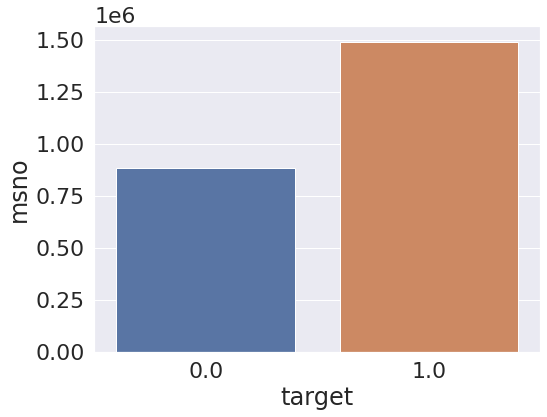

In [199]:
data = train_merged.groupby('target').aggregate({'msno':'count'}).reset_index()
a4_dims = (8, 6)
fig, ax = plt.subplots(figsize=a4_dims)
ax = sns.barplot(x='target', y='msno', data=data)

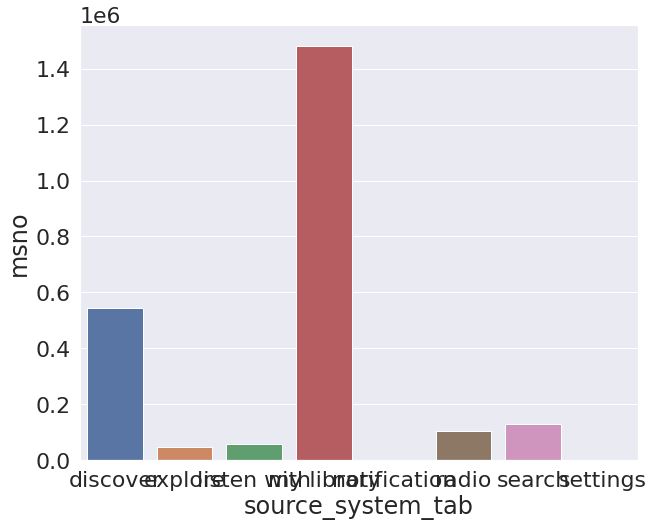

In [230]:
mpl.rcParams['font.size'] = 40.0
plt.figure(figsize = (10, 8)) 
data=train_merged.groupby('source_system_tab').aggregate({'msno':'count'}).reset_index()
sns.barplot(x='source_system_tab',y='msno',data=data)

[Text(0, 0, 'Album more'),
 Text(0, 0, 'Artist more'),
 Text(0, 0, 'Concert'),
 Text(0, 0, 'Discover Chart'),
 Text(0, 0, 'Discover Feature'),
 Text(0, 0, 'Discover Genre'),
 Text(0, 0, 'Discover New'),
 Text(0, 0, 'Explore'),
 Text(0, 0, 'Local playlist more'),
 Text(0, 0, 'My library'),
 Text(0, 0, 'My library_Search'),
 Text(0, 0, 'Online playlist more'),
 Text(0, 0, 'Others profile more'),
 Text(0, 0, 'Payment'),
 Text(0, 0, 'Radio'),
 Text(0, 0, 'Search'),
 Text(0, 0, 'Search Home'),
 Text(0, 0, 'Search Trends'),
 Text(0, 0, 'Self profile more'),
 Text(0, 0, 'Unknown')]

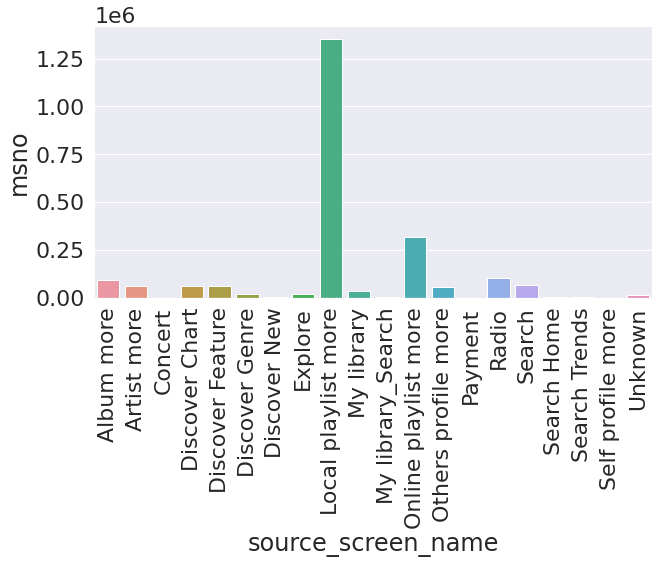

In [201]:
data = train_merged.groupby('source_screen_name').aggregate({'msno':'count'}).reset_index()
a4_dims = (10, 5)
fig, ax = plt.subplots(figsize=a4_dims)
ax = sns.barplot(x='source_screen_name', y='msno', data=data)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

[Text(0, 0, 'album'),
 Text(0, 0, 'artist'),
 Text(0, 0, 'listen-with'),
 Text(0, 0, 'local-library'),
 Text(0, 0, 'local-playlist'),
 Text(0, 0, 'online-playlist'),
 Text(0, 0, 'radio'),
 Text(0, 0, 'song'),
 Text(0, 0, 'song-based-playlist'),
 Text(0, 0, 'top-hits-for-artist'),
 Text(0, 0, 'topic-article-playlist')]

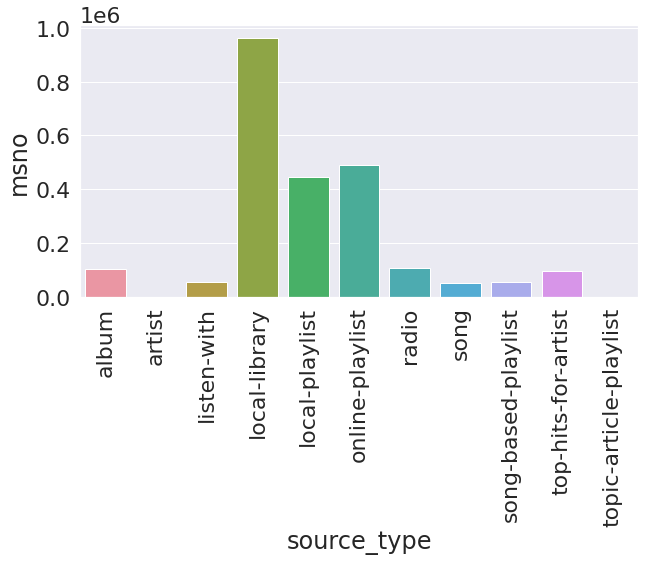

In [202]:
data = train_merged.groupby('source_type').aggregate({'msno':'count'}).reset_index()
a4_dims = (10, 5)
fig, ax = plt.subplots(figsize=a4_dims)
ax = sns.barplot(x='source_type', y='msno', data=data)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

[Text(0, 0, '-5'),
 Text(0, 0, '-1'),
 Text(0, 0, '3'),
 Text(0, 0, '10'),
 Text(0, 0, '17'),
 Text(0, 0, '24'),
 Text(0, 0, '31'),
 Text(0, 0, '38'),
 Text(0, 0, '45'),
 Text(0, 0, '52'),
 Text(0, 0, '59')]

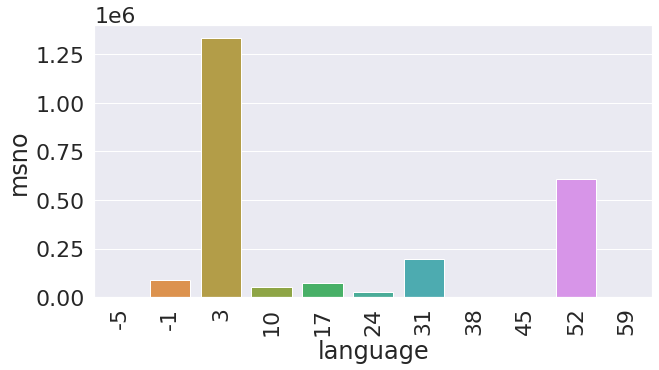

In [203]:
data = train_merged.groupby('language').aggregate({'msno':'count'}).reset_index()
a4_dims = (10, 5)
fig, ax = plt.subplots(figsize=a4_dims)
ax = sns.barplot(x='language', y='msno', data=data)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

[Text(0, 0, '-5'),
 Text(0, 0, '3'),
 Text(0, 0, '4'),
 Text(0, 0, '7'),
 Text(0, 0, '9'),
 Text(0, 0, '13')]

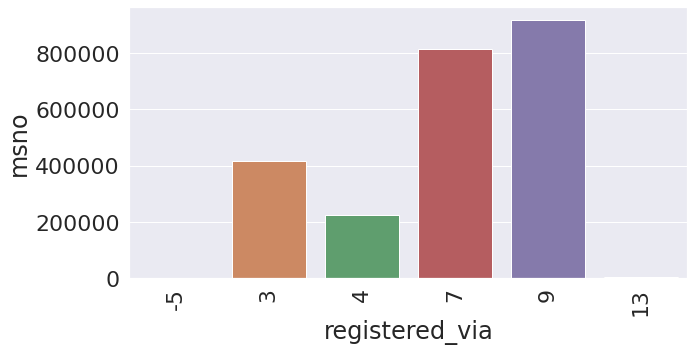

In [231]:
data = train_merged.groupby('registered_via').aggregate({'msno':'count'}).reset_index()
a4_dims = (10, 5)
fig, ax = plt.subplots(figsize=a4_dims)
ax = sns.barplot(x='registered_via', y='msno', data=data)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

##### most users 7 and 9 ways to get registered

Index(['msno', 'song_id', 'source_system_tab', 'source_screen_name',
       'source_type', 'target', 'city', 'bd', 'gender', 'registered_via',
       'registration_init_time', 'expiration_date', 'song_length', 'genre_ids',
       'artist_name', 'composer', 'lyricist', 'language'],
      dtype='object')


[Text(0, 0, '-5'),
 Text(0, 0, '1'),
 Text(0, 0, '3'),
 Text(0, 0, '4'),
 Text(0, 0, '5'),
 Text(0, 0, '6'),
 Text(0, 0, '7'),
 Text(0, 0, '8'),
 Text(0, 0, '9'),
 Text(0, 0, '10'),
 Text(0, 0, '11'),
 Text(0, 0, '12'),
 Text(0, 0, '13'),
 Text(0, 0, '14'),
 Text(0, 0, '15'),
 Text(0, 0, '16'),
 Text(0, 0, '17'),
 Text(0, 0, '18'),
 Text(0, 0, '19'),
 Text(0, 0, '20'),
 Text(0, 0, '21'),
 Text(0, 0, '22')]

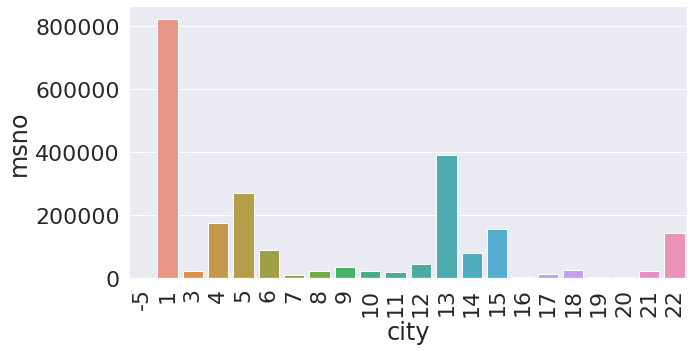

In [233]:
print(train_merged.columns)
data = train_merged.groupby('city').aggregate({'msno':'count'}).reset_index()
a4_dims = (10, 5)
fig, ax = plt.subplots(figsize=a4_dims)
ax = sns.barplot(x='city', y='msno', data=data)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

#### no of users are 1,13,5 are containig maximum values

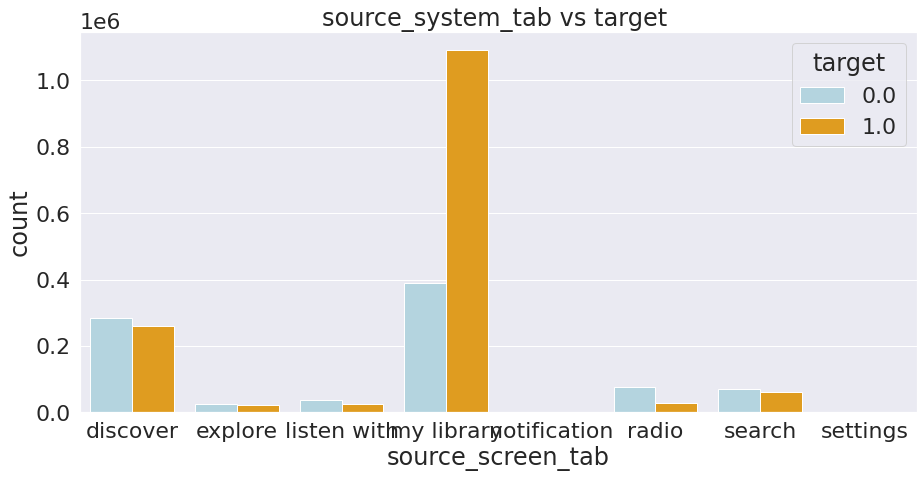

In [206]:
a4_dims = (15, 7)
fig, ax = plt.subplots(figsize=a4_dims)
ax=sns.countplot(x="source_system_tab",data=train_merged,palette=['lightblue','orange','green'],hue="target")
plt.xlabel("source_screen_tab")
plt.ylabel("count")
plt.title("source_system_tab vs target ")
plt.show()

#### new user are coming form discover and my llibrary and old ones are from my library

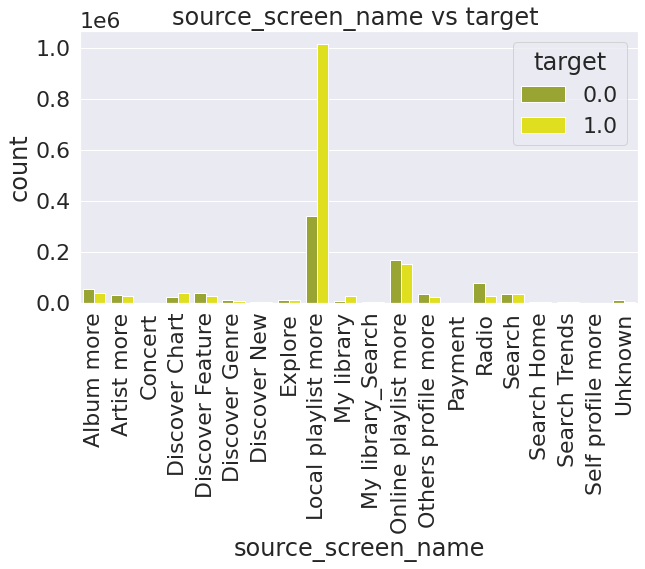

In [207]:
a4_dims = (10, 5)
fig, ax = plt.subplots(figsize=a4_dims)
ax=sns.countplot(x="source_screen_name",data=train_merged,palette=['#A8B820','yellow','#98D8D8'],hue="target")
plt.xlabel("source_screen_name")
plt.ylabel("count")
plt.title("source_screen_name vs target ")
plt.xticks(rotation='90')
plt.show()

#### local playlist among new user and old one more most common way to get back their songs

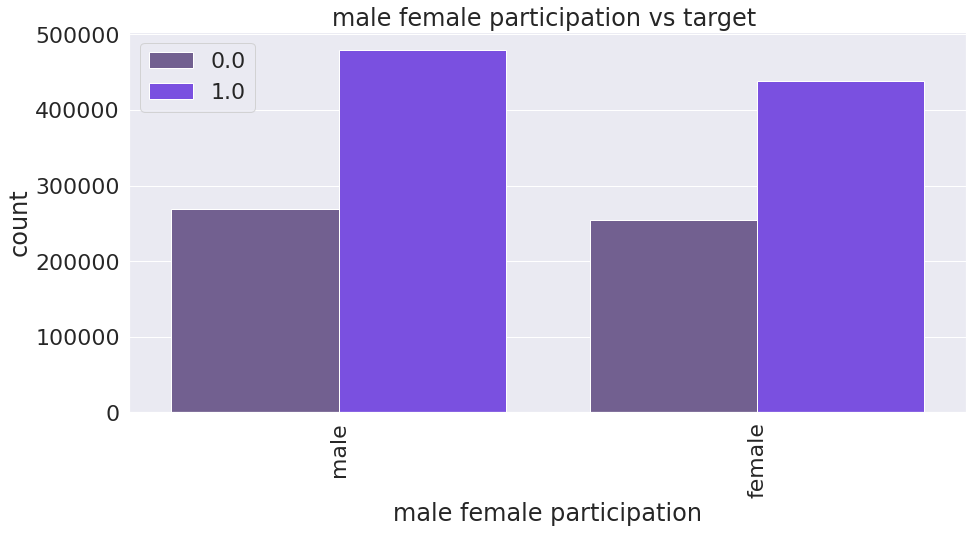

In [208]:
a4_dims = (15, 7)
fig, ax = plt.subplots(figsize=a4_dims)
ax=sns.countplot(x="gender",data=train_merged,palette=['#705898','#7038F8','yellow'],hue="target")
plt.xlabel("male female participation")
plt.ylabel("count")
plt.title("male female participation vs target ")
plt.xticks(rotation='90')
plt.legend(loc='upper left')
plt.show()

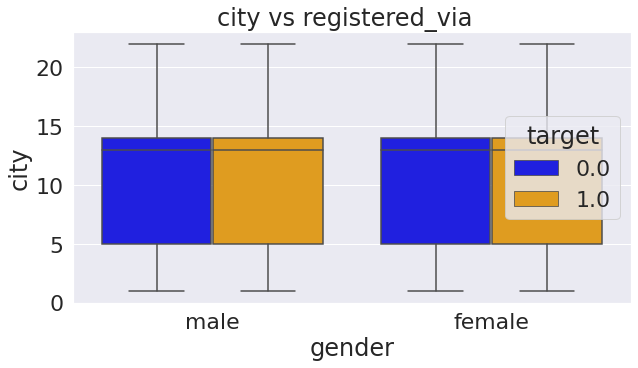

In [209]:
a4_dims = (10, 5)
fig, ax = plt.subplots(figsize=a4_dims)
ax=sns.boxplot(x="gender",y="city",data=train_merged,palette=['blue','orange','green'],hue="target")
plt.xlabel("gender")
plt.ylabel("city")
plt.title("city vs registered_via  ")
plt.show()

In [210]:
print('Shape of train is :',train.shape)
print('Shape of test is :',test.shape)
print('Shape of Song Extra Info is :',sei.shape)
print('Shape of Members is :',members.shape)
print('Shape of Songs is :',songs.shape)

Shape of train is : (2377804, 6)
Shape of test is : (2335865, 6)
Shape of Song Extra Info is : (2295971, 3)
Shape of Members is : (34403, 7)
Shape of Songs is : (2296320, 7)


In [211]:
def get_codes(isrc):
    if pd.isnull(isrc):
        return np.nan
    else:
        if int(str(isrc)[5:7]) > 17:
            temp =  1900+int(str(isrc)[5:7])
        else:
            temp = 2000+int(isrc[5:7])
        return temp

In [212]:
sei['year'] = sei['isrc'].apply(lambda x: get_codes(x))
sei.sample(10)

,song_id,name,isrc,year
65414,yJsm7nYKbIX5Br6NKzHuc+Sn8QlHWUfKI+HWUEuqWjg=,Aad Guray,USKHG1000021,2010.0
38560,XTaJuwTy8xQ1EnZv9UuV6R7mrb5BbZ8GbWmOPmP6+3E=,Sakurairono Kisetsu,JPI100501119,2005.0
596736,kU6Grwc0gszPfO63RCdv/7jeU603mmdZX0DdjvCA/6s=,Natividad,NLA329201900,1992.0
2067221,UCmpNCWF7jsCleGe1nkWIMWTk0BrGDLx0hGfz310HpI=,Must Be Catchin',DEPZ68808773,1988.0
67183,1PjudrK4m72s3sTI2uc2wIxCgBlCqyQcHyqEJtEvw10=,Will Common,UKACT1662394,2016.0
495298,qX1ayLFo0pQt0tY/jyFJKeynx17PpNypmVrear++fV4=,Someone to Watch Over Me,US4EB0936006,2009.0
1002579,cV9r7I6SA/yU1VZEuo+o/JmqejREJnx2yCL8+xS5Uos=,Warrior Without a War,USMBR1511012,2015.0
305999,st9b0N2xN22VL2xuMcbxPnk+JMn/M1g6ZA8IBZEyy5w=,II. Canzonetta (Andante),DEN960803342,2008.0
1299246,Bem0MD/KV2zhBvPQ7tEEr1LVs0Atz612R0JtpvIXaCU=,Killin Em Girl,US7SF1656127,2016.0
1615870,TF2UqShdyB2Rvn5f5SZkhMjum0khH4jAECPAjYLEiAY=,Hotels And Beds,US85P0863005,2008.0


In [213]:
members['membership_days'] = members['expiration_date'].subtract(members['registration_init_time']).dt.days.astype(int)
members['registration_year'] = members['registration_init_time'].dt.year
members['expiration_year'] = members['expiration_date'].dt.year
members.drop(columns = ['registration_init_time' , 'expiration_date'] , inplace = True)
members.head()

,msno,city,bd,gender,registered_via,membership_days,registration_year,expiration_year
0,XQxgAYj3klVKjR3oxPPXYYFp4soD4TuBghkhMTD4oTw=,1,0,NaN,7,2223,2011,2017
1,UizsfmJb9mV54qE9hCYyU07Va97c0lCRLEQX3ae+ztM=,1,0,NaN,7,725,2015,2017
2,D8nEhsIOBSoE6VthTaqDX8U6lqjJ7dLdr72mOyLya2A=,1,0,NaN,4,457,2016,2017
3,mCuD+tZ1hERA/o5GPqk38e041J8ZsBaLcu7nGoIIvhI=,1,0,NaN,9,1,2015,2015
4,q4HRBfVSssAFS9iRfxWrohxuk9kCYMKjHOEagUMV6rQ=,1,0,NaN,4,138,2017,2017


In [214]:
# Extending columns
# merging the database
train = train.merge(songs , on='song_id' , how='left')
train = train.merge(members , on = 'msno' , how='left')
train = train.merge(sei , on = 'song_id' , how='left')
test  = test.merge(songs , on='song_id' , how='left')
test = test.merge(members , on = 'msno' , how = 'left')
test =  test.merge(sei , on = 'song_id' , how = 'left')
del sei ,members , songs
gc.collect()

2424

In [215]:
print(train['song_length'].isnull().value_counts()/train.shape[0])
train['song_length'].fillna(train['song_length'].mean() , inplace = True)
train['song_length'] = train['song_length'].astype(np.uint32)
print(train['language'].isnull().value_counts()/train.shape[0])
train['language'].fillna(train['language'].mode().values[0] , inplace= True)
train['language'] = train['language'].astype(np.int8)
test['song_length'].fillna(test['song_length'].mean() , inplace = True)
test['song_length'] = test['song_length'].astype(np.uint32)
test['language'].fillna(test['language'].mode().values[0] , inplace= True)
test['language'] = test['language'].astype(np.int8)

False    0.999983
True     0.000017
Name: song_length, dtype: float64
False    0.999977
True     0.000023
Name: language, dtype: float64


In [216]:
def genre_count(genre):
    if genre == 'no_genre_id':
        return 0
    else :
        return genre.count('|') + 1
print(train['genre_ids'].isnull().value_counts()/train.shape[0])
train['genre_ids'].fillna('no_genre_id' , inplace= True)
train['genre_ids_count'] = train['genre_ids'].apply(lambda x: genre_count(x)).astype(np.int8)
test['genre_ids'].fillna('no_genre_id' , inplace= True)
test['genre_ids_count'] = test['genre_ids'].apply(lambda x: genre_count(x)).astype(np.int8)

False    0.985296
True     0.014704
Name: genre_ids, dtype: float64


In [217]:
def artist_count(art):
    if art=='no_artist_name':
        return 0
    else:
        return art.count('|')+art.count('/') + art.count('//') + art.count(';') + 1
train['artist_name'].isnull().value_counts()
train['artist_name'].fillna('no_artist_name' , inplace = True)
train['artist_count'] = train['artist_name'].apply(lambda x : artist_count(x)).astype(np.int8)
test['artist_name'].fillna('no_artist_name' , inplace = True)
test['artist_count'] = test['artist_name'].apply(lambda x : artist_count(x)).astype(np.int8)

In [218]:
def  count_composer(comp):
    if comp=='no_composer':
        return 0
    else:
        return comp.count('|')+comp.count('/') + comp.count('//') + comp.count(';') + 1
def  count_lyricist(lyr):
    if lyr=='no_lyricist':
        return 0
    else:
        return lyr.count('|')+lyr.count('/') + lyr.count('//') + lyr.count(';') + 1

In [219]:
train['composer'].fillna('no_composer',inplace=True)
train['composer_count'] = train['composer'].apply(lambda x: count_composer(x)).astype(np.int8)
train['lyricist'].fillna('no_lyricist',inplace=True)
train['lyricist_count'] = train['lyricist'].apply(lambda x: count_lyricist(x)).astype(np.int8)
test['composer'].fillna('no_composer',inplace=True)
test['composer_count'] = test['composer'].apply(lambda x: count_composer(x)).astype(np.int8)
test['lyricist'].fillna('no_lyricist',inplace=True)
test['lyricist_count'] = test['lyricist'].apply(lambda x: count_lyricist(x)).astype(np.int8)

In [220]:
dict_count_song_played_train = {k: v for k, v in train['song_id'].value_counts().iteritems()}
dict_count_song_played_test = {k: v for k, v in test['song_id'].value_counts().iteritems()}
def return_number_played(x):
    try:
        return dict_count_song_played_train[x]
    except KeyError:
        try:
            return dict_count_song_played_test[x]
        except KeyError:
            return 0
train['number_of_time_played'] = train['song_id'].apply(lambda x: return_number_played(x))
test['number_of_time_played'] = test['song_id'].apply(lambda x: return_number_played(x))

In [221]:
dict_user_activity = {k:v for k,v in pd.concat([train['msno'] , test['msno']] , axis = 0).value_counts().iteritems()}
def return_user_activity(x):
    try:
        return dict_user_activity[x]
    except KeyError:
        return 0
train['user_activity_msno'] = train['msno'].apply(lambda x: return_user_activity(x))
test['user_activity_msno'] = test['msno'].apply(lambda x: return_user_activity(x))

In [222]:
train_col = list(train.columns)
test_col = list(test.columns)
for f in test_col :
    if f not in train_col:
        print('ERROR !!!  Column from Test not found in train is ->' , f)
label_encoding = ['source_system_tab', 'source_screen_name',
       'source_type','gender']
drop = ['msno', 'song_id' , 'isrc','artist_name',
       'composer', 'lyricist','name','genre_ids']
min_max_scaling = ['number_of_time_played', 'user_activity_msno','membership_days', 'song_length']

ERROR !!!  Column from Test not found in train is -> id


In [223]:
for f in label_encoding:
    lb = LabelEncoder()
    lb.fit(list(train[f].values) + list(test[f].values))
    train[f] = lb.transform(list(train[f].values))
    test[f] = lb.transform(list(test[f].values))
for f in min_max_scaling:
    ms = MinMaxScaler()
    train[f] = ms.fit_transform(train[[f]])
    test[f] = ms.transform(test[[f]])
# train.drop(columns = drop , inplace = True)
# test.drop(columns=drop , inplace = True)

In [224]:
for col in train.columns:
    if train[col].dtype == object:
        train[col] = train[col].astype('category')
        test[col] = test[col].astype('category')

In [225]:
train.sample(10)

,msno,song_id,source_system_tab,source_screen_name,source_type,target,song_length,genre_ids,artist_name,composer,lyricist,language,city,bd,gender,registered_via,membership_days,registration_year,expiration_year,name,isrc,year,genre_ids_count,artist_count,composer_count,lyricist_count,number_of_time_played,user_activity_msno
1842585,RnTFiABVa2UXOFchSQN9spLnHWaBFZ+PPXSktSXIWvM=,SWrI7mjHeJmM9VzbXxozLFxaDbx6LPDFZ9i5R/MmkR8=,3,8,4,1.0,0.021567,465,王俊凱 (Karry Wang),no_composer,no_lyricist,3,1,23,1,4,0.013595,2016,2017,樹讀 (The Wish Of A Tree),TWA531636508,2016.0,1,1,0,0,0.105437,0.155122
1855252,YQiox2a4tbRbNBaL+VfOLH8oea77HPJMPWRh8euXZqM=,DPILQorRPoY9WJ8S1bjZzN/VvyLdmDSUy2AlQvoo5PI=,3,8,4,1.0,0.024020,465,范瑋琪 (Christine Fan),范瑋琪,王雅君,3,13,20,1,3,0.425520,2012,2018,灰色的彩虹,TWA210924004,2009.0,1,1,1,1,0.015620,0.326825
1737260,QNCdfyrJt5XQRK2wKwsu/e5/P2koa0+xt99LFuXOhPQ=,uEl0qdm9OsNg8dkJmHT1EIidNr9EyAD+1q0MwTYS/qY=,0,11,7,0.0,0.020081,458,英皇團員,Panot Khunprasert / Prakarn Raiva,崔恕,3,5,49,0,9,0.053797,2016,2017,團圓飯,HKD251600024,2016.0,1,1,2,1,0.129919,0.056432
1967303,FY7fdESg7yzc8LJHZcE0ZtoRwDzsQue91B2M/zYZVx0=,zVzlkFItud6fDiF/1KerCYikIsLDFrKnd/QDhe1ys3g=,3,8,4,0.0,0.021704,359,Coldplay,Chris Martin| Guy Berryman| Jonny Buckland| To...,no_lyricist,52,1,0,2,7,0.415615,2011,2017,Up&Up,GBAYE1600464,2016.0,1,1,6,0,0.007660,0.144424
1046424,EJoW0sIOspRw0NryicAKsFPR1zXVEylC/+RyeoXuco4=,dSzFGa1wcCJBFWmmgV/45V7VunXRzc8jurkpORWnOM4=,3,8,4,0.0,0.022826,465,陳勢安 (Andrew Tan),戴佩妮,戴佩妮,3,22,41,1,9,0.841717,2005,2017,非你不可,MYPN11313101,2013.0,1,1,1,1,0.054371,0.134795
67233,Sm5k3HdfDfxrC4+2HwQUZ5jb8Ci4P1S2i/aEtbkMeOA=,UcjD/JCft4oWQhmQyoAiVFSdDgSLPEPjpZiaY4HX9BA=,7,11,7,0.0,0.026554,465,五月天 (Mayday),瑪莎,阿信,3,22,0,2,9,0.078268,2016,2017,最重要的小事,TWA450689707,2006.0,1,1,1,1,0.035746,0.355978
1729012,rFw0oTNusma/MoJTJ051O02CYh5uRq6jibWhSVTZfxY=,m72nO+UIKi9bNCw5n7/eKQkrGJXpRFGdLUvq1+kkuUc=,3,8,4,0.0,0.024746,465,黃鴻升 (Alien Huang),張簡君偉,張簡君偉/葛大為,3,1,0,2,7,0.159060,2015,2017,有感情歌,TWA451441602,2014.0,1,1,1,2,0.020727,0.125435
1274082,bv3iExO/Vuh8/7SctiX8QkZCcWG4qW2f36X+PckZdgs=,++QfzyM/LiFaCuvkDFK/wJe13ZEMgTgAaVCcolo7nnY=,0,11,7,1.0,0.019569,444,TWICE,Black Eyed Win 1,no_lyricist,31,7,34,1,3,0.289571,2013,2017,Like OOH-AHH,US5TA1500093,2015.0,1,1,1,0,0.215680,0.105643
1812983,OVT1afKoXawfczyQ19qccBtN6aXgAvgY2+ptTA+j7A0=,0cHV60MVnGOKMb/GRHWEExfpahkCwIZQ0wxdYBJfoqE=,0,11,7,0.0,0.020611,921,Various Artists,鄭楠,藍小邪,3,1,0,2,7,0.253059,2014,2017,姐 (Pretty Woman),TWD951564102,2015.0,1,1,1,1,0.119856,0.134795
2101349,7Vp31+gBj5m0/EnJSe9QK9d8+snCn8k2FQv3uc5DGpI=,rty4zNLxyEIW0CC7fRo6ffxnhX3HCQPSHhVGviVM04o=,3,8,4,0.0,0.021213,1259,Various Artists,no_composer,no_lyricist,52,15,34,1,9,0.350942,2013,2018,Go Hard or Go Home,USAT21500311,2015.0,1,1,0,0,0.019075,0.023536


In [226]:
X_train = train.drop(columns = ['target'] , axis = 1)
Y_train = train['target'].values
X_test = test.drop(columns = ['id'] , axis = 1)
ids = test['id'].values
del train , test
gc.collect()
train_set = lgb.Dataset(X_train , Y_train)

In [227]:
params = {
        'objective': 'binary',
        'metric': 'binary_logloss',
        'boosting': 'gbdt',
        'learning_rate': 0.3 ,
        'verbose': 0,
        'num_leaves': 108,
        'bagging_fraction': 0.95,
        'bagging_freq': 1,
        'bagging_seed': 1,
        'feature_fraction': 0.9,
        'feature_fraction_seed': 1,
        'max_bin': 256,
        'max_depth': 10,
        'num_rounds': 200,
        'metric' : 'auc'
    }

%time model_f1 = lgb.train(params, train_set=train_set,  valid_sets=train_set, verbose_eval=5)

[5]	training's auc: 0.78361
[10]	training's auc: 0.801045
[15]	training's auc: 0.810801
[20]	training's auc: 0.816946
[25]	training's auc: 0.822381
[30]	training's auc: 0.825945
[35]	training's auc: 0.829007
[40]	training's auc: 0.831508
[45]	training's auc: 0.834075
[50]	training's auc: 0.836484
[55]	training's auc: 0.838357
[60]	training's auc: 0.840136
[65]	training's auc: 0.842252
[70]	training's auc: 0.843715
[75]	training's auc: 0.845145
[80]	training's auc: 0.846832
[85]	training's auc: 0.848771
[90]	training's auc: 0.849911
[95]	training's auc: 0.851075
[100]	training's auc: 0.852198
[105]	training's auc: 0.8535
[110]	training's auc: 0.854491
[115]	training's auc: 0.855455
[120]	training's auc: 0.856852
[125]	training's auc: 0.857684
[130]	training's auc: 0.858491
[135]	training's auc: 0.859676
[140]	training's auc: 0.86081
[145]	training's auc: 0.861568
[150]	training's auc: 0.862262
[155]	training's auc: 0.862887
[160]	training's auc: 0.863525
[165]	training's auc: 0.864189
[

In [228]:
pred_test = model_f1.predict(X_test)
print('Saving Predictions')
sub = pd.DataFrame()
sub['id'] = ids
sub['target'] = pred_test
sub.to_csv('1st_submission.csv' , index = False , float_format ='%.5f' )

Saving Predictions


In [229]:
sub.head()

,id,target
0,0,0.680596
1,1,0.776032
2,2,0.124183
3,3,0.175804
4,4,0.123520
